<a href="https://colab.research.google.com/github/akansh12/Deep-Learning-for-imaging-EE5179/blob/main/Assignment_1/PA1_CS22Z003.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST Classification using MLP


By 
- Akansh Maurya (CS22Z003)

Tasks to to:
- Baseline: IP-h(500)-h(250)-h(100)-OP
- Activation functions for hidden layers: Sigmoid and for the Output layer it is softmax
- Gradient-Descent
- lr = 0.01, batch size = 64, epoch = 15
-  Extra marks for experimentations
- Glorot Initialization
- Plot the loss for 200 iterations
- Confustion matrix and classification report
1.1
- Use Tanh and RELU

Task 2:
- Use pytorch for the same
- Add L2 Regularization to it.

###Imports

In [1]:
import tensorflow as tf
import torch
import keras
import torchvision
import numpy as np
from  matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

Downloading the Dataset

In [2]:
# source: https://keras.io/api/datasets/mnist/
tf.keras.datasets.mnist.load_data(path="mnist.npz")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


### Reshaping the dataset

In [3]:
x_train = np.array(x_train.reshape(x_train.shape[0], 784)).T
x_test = np.array(x_test.reshape(x_test.shape[0], 784)).T
x_train = (x_train/255.0).astype(np.float32)
x_test = (x_test/255.0).astype(np.float32)

In [4]:
print("Train Dataset Shape: ", x_train.shape)
print("Train Target Vector Shape: ", y_train.shape) 
print("Test Dataset Shape:", x_test.shape)
print("Test Target Vector Shape", y_test.shape)

Train Dataset Shape:  (784, 60000)
Train Target Vector Shape:  (60000,)
Test Dataset Shape: (784, 10000)
Test Target Vector Shape (10000,)


9
7


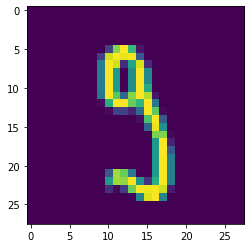

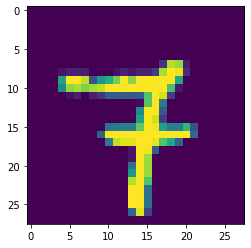

In [6]:
plt.figure()
plt.imshow(x_train[:,48].reshape(28,28))
print(y_train[48])
plt.figure()
plt.imshow(x_test[:,75].reshape(28,28))
print(y_test[75])

In [ ]:
class MLP():
  def __init__(self, epochs, num_input_nodes, hidden_layers, num_output_nodes, lr, optimizer, batch_size, activation_function = 'sigmoid', loss_type = 'cross_entropy', w_initial = 'glorot'):
    self.epochs = epochs
    self.lr = lr 
    self.optimizer = optimizer
    self.optimizer.lr = self.lr      
    self.batch_size = batch_size
    self.num_input_nodes = num_input_nodes
    self.hidden_layers = hidden_layers
    self.num_output_nodes = num_output_nodes
    self.loss_type = loss_type
    #Activation function
    self.activation_function = self.sigmoid
    #parameter initialization
    self.params = self.initialization(weight_initialisation = w_initial)

  def sigmoid(self,x, derivative = False):
    if derivative:
      return self.sigmoid(x)*(1-self.sigmoid(x))
    else:
      return 1/(1 + np.exp(-x))

  def one_hot(self,y):
    v = np.zeros((self.num_output_nodes, len(y)))
    for i,j in enumerate(y):
      v[j,i] = 1
    return v

  def softmax(self,x,derivative = False):
    if derivative:
      return self.softmax(x)*(1- self.softmax(x))
    else:
      return (np.exp(x)/np.sum(np.exp(x), axis = 0))
  def loss(self, y_pred, y_true):
    if self.loss_type == 'cross_entropy':
      return -1*np.mean(np.multiply(self.one_hot(y_true), np.log(y_pred))) # To Do: Optimize this using argmax

  def initialization(self, weight_initialisation = 'random'):
    w = []
    b = []

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*np.sqrt(2/(self.num_input_nodes+self.hidden_layers[0])))
    b.append(np.zeros((self.hidden_layers[0], 1))) 

    for i in range(1,len(self.hidden_layers)):
      if weight_initialisation == 'random':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*0.1)
      elif weight_initialisation == 'Xavier':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*np.sqrt(2/(self.hidden_layers[i-1]+self.hidden_layers[i])))
      b.append(np.zeros((self.hidden_layers[i], 1)))

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*np.sqrt(2/(self.hidden_layers[len(self.hidden_layers)-1] + self.num_output_nodes)))
    b.append(np.zeros((self.num_output_nodes, 1)))

    return {'w':w, 'b':b}

  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.h.append(x)

    for i in range(0, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][-1],self.h[-1])+self.params['b'][-1])

    y_hat = self.softmax(self.a[-1])
    return y_hat

  def back_propagation(self, y_hat, y_true):
    self.da = [0]* len(self.a)
    self.dh = [0]* len(self.h)-1
    self.dw = [0]* len(self.params['w'])
    self.db = [0]* len(self.params['b'])

    self.da[-1] = -1*(y_true - y_hat)

    for i in range(len(self.params['w'])-1, 0, -1):
      self.dw[i] = np.dot(self.da[i], self.h[i].T) 
      self.db[i] = self.da[i]

      self.dh[i-1] = np.dot(self.params['w'][i].T, self.da[i])
      self.da[i-1] = np.multiply(self.dh[i-1], self.activation_function(self.da[i-1], derivative=True))
    self.dw[0] = self.da[0], self.dh[0].T
    self.db[0] = self.da[0]

    return self.dw, self.db


In [ ]:
  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.h.append(x)

    for i in range(0, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][-1],self.h[-1])+self.params['b'][-1])

    y_hat = self.softmax(self.a[-1])
    return y_hat

In [ ]:
x_train.shape

(60000, 784)

In [ ]:
A.shape

(10, 60000)

In [ ]:
class DeepNeuralNetwork():
  def __init__(self,epochs,num_input_nodes, hidden_layers,num_output_nodes, lr, weight_decay, optimizer, batch_size, w_initial, activation_function = 'sigmoid', loss_type = 'cross_entropy'):
    self.epochs = epochs
    self.lr = lr 
    self.weight_decay = weight_decay
    self.optimizer = optimizer
    self.optimizer.lr = self.lr      
    self.batch_size = batch_size
    self.num_input_nodes = num_input_nodes
    self.hidden_layers = hidden_layers
    self.num_output_nodes = num_output_nodes
    self.loss_type = loss_type
    #Activation function
    self.activation_function = self.activation(activation_function)

    #parameter initialization
    self.params = self.initialization(weight_initialisation = w_initial)


  def initialization(self, weight_initialisation = 'random'):
    w = []
    b = []

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.hidden_layers[0],self.num_input_nodes)*np.sqrt(2/(self.num_input_nodes+self.hidden_layers[0])))
    b.append(np.zeros((self.hidden_layers[0], 1)))  #np.random.randn(self.hidden_layers[0],1)*0.01

    for i in range(1,len(self.hidden_layers)):
      if weight_initialisation == 'random':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*0.1)
      elif weight_initialisation == 'Xavier':
        w.append(np.random.randn(self.hidden_layers[i],self.hidden_layers[i-1])*np.sqrt(2/(self.hidden_layers[i-1]+self.hidden_layers[i])))
      #b.append(np.random.randn(self.hidden_layers[i],1)*0.01)
      b.append(np.zeros((self.hidden_layers[i], 1)))

    if weight_initialisation == 'random':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*0.1)
    elif weight_initialisation == 'Xavier':
      w.append(np.random.randn(self.num_output_nodes,self.hidden_layers[len(self.hidden_layers)-1])*np.sqrt(2/(self.hidden_layers[len(self.hidden_layers)-1] + self.num_output_nodes)))
    #b.append(np.random.randn(self.num_output_nodes,1)*0.01)
    b.append(np.zeros((self.num_output_nodes, 1)))

    return {'w':w, 'b':b}

  def activation(self, activation_function):

    if activation_function == 'sigmoid':
      return self.sigmoid
    if activation_function == 'tanh':
      return self.tanh
    if activation_function == 'ReLU':
      return self.relu

  def sigmoid(self,x, derivative = False):
    if derivative:
      return (1/(1 + np.exp(-x)))*(1-(1/(1 + np.exp(-x))))#self.sigmoid(x)*(1-self.sigmoid(x))
    else:
      return 1/(1 + np.exp(-x))  

  def tanh(self, x, derivative = False):
    if derivative:
      return 1 - self.tanh(x)**2
    return (np.exp(x)-np.exp(-x))/(np.exp(x)+np.exp(-x))

  def relu(self, x, derivative = False):
    if derivative:
      return (x>0)*1 
    return x*(x>0)

  def softmax(self,x,derivative = False):
    if derivative:
      return (np.exp(x)/np.sum(np.exp(x), axis = 0))*(1- (np.exp(x)/np.sum(np.exp(x), axis = 0))) #self.softmax(x)*(1- self.softmax(x))
    else:
      return (np.exp(x)/np.sum(np.exp(x), axis = 0))

  def one_hot(self,y):
    v = np.zeros((self.num_output_nodes, len(y)))
    for i,j in enumerate(y):
      v[j,i] = 1
    return v
    

  def compute_accuracy(self, x_val, y_val):

    from sklearn.metrics import accuracy_score

    x_val = x_val.reshape(self.num_input_nodes, -1)

    out = self.feed_forward(x_val)
    pred = np.argmax(out, axis = 0)

    acc=accuracy_score(y_val, pred, normalize=True, sample_weight=None)


    return np.mean(pred == y_val)*100



  def loss(self, y_pred, y_true):
    if self.loss_type == 'cross_entropy':
      return -1*np.sum(np.multiply(self.one_hot(y_true), np.log(y_pred)))
    if self.loss_type == 'mean_square_error':
      return np.mean((self.one_hot(y_true) - y_pred) ** 2) #np.sum((self.one_hot(y_true) - y_pred) ** 2)*0.5

  def feed_forward(self, x):
    #a=wh+b
    #h=activation function(a)
    self.a = []
    self.h = []
    self.a.append(np.dot(self.params['w'][0], x) + self.params['b'][0])
    self.h.append(self.activation_function(self.a[0]))

    for i in range(1, len(self.hidden_layers)):
      self.a.append(np.dot(self.params['w'][i], self.h[i-1])+ self.params['b'][i])
      self.h.append(self.activation_function(self.a[i]))

    self.a.append(np.dot(self.params['w'][len(self.hidden_layers)],self.h[len(self.hidden_layers)-1])+self.params['b'][len(self.hidden_layers)])

    out = self.softmax(self.a[len(self.hidden_layers)])
    return out
    """
  def back_propagation(self,x, y_train,y_train_prob):
    self.ga= [0]*(len(self.a))
    self.gh= [0]*(len(self.h)) 
    self.gW= [0]*(len(self.params['w']))
    self.gB= [0]*(len(self.params['b']))

    if self.loss_type == 'cross_entropy':
      self.ga[len(self.hidden_layers)]= -1*(self.one_hot(y_train)-y_train_prob)

    if self.loss_type== 'mean_square_error': 
      self.ga[len(self.hidden_layers)]= np.multiply(2 *(y_train_prob -self.one_hot(y_train)), np.multiply(y_train_prob, (1 - y_train_prob)))
      
  
      #(self.one_hot(y_train)-y_train_prob)*self.one_hot(y_train)*(1 - self.one_hot(y_train))  ## Check this Y-->y_train_prob,Y_train_batch->y_train

    for i in range(len(self.hidden_layers), 0,-1):
      self.gW[i] = np.outer(self.ga[i], self.h[i-1])   ###
      self.gB[i] = self.ga[i]

      self.gh[i-1] = np.matmul(self.params['w'][i].T, self.ga[i])
      self.ga[i-1] = np.multiply(self.gh[i-1], self.activation_function(self.a[i-1], derivative = True))  ### Check this
    
    self.gW[0] = np.dot(self.ga[0], x.T)
    self.gB[0] = np.dot(self.ga[0], np.ones((self.batch_size, 1)))

    return self.gW, self.gB
    """
########
    
  def back_propagation(self,x, y_train,y_train_prob):
    self.ga= [0]*(len(self.a))
    self.gh= [0]*(len(self.h)) 
    self.gW= [0]*(len(self.params['w']))
    self.gB= [0]*(len(self.params['b']))
    #num_layers=len(self.hidden_layers)+1
    num_layers=len(self.params['w'])+1
    gradients_weights = []
    gradients_biases = []
    if self.loss_type == 'cross_entropy':
      self.ga[num_layers-1]= -1*(self.one_hot(y_train)-y_train_prob)

    if self.loss_type== 'mean_square_error': 
      self.ga[num_layers-1]= np.multiply(2 *(y_train_prob -self.one_hot(y_train)), np.multiply(y_train_prob, (1 - y_train_prob)))
      
  
      #(self.one_hot(y_train)-y_train_prob)*self.one_hot(y_train)*(1 - self.one_hot(y_train))  ## Check this Y-->y_train_prob,Y_train_batch->y_train

    for i in range(num_layers -2, -1,-1):
      self.gW[i+1] = np.outer(self.ga[i+1], self.h[i])   ###
      self.gB[i+1] = self.ga[i+1]
      gradients_weights.append(self.gW[i+1])
      gradients_biases.append(self.gB[i+1])
      if i!=0:
        self.gh[i] = np.matmul(self.params['w'][i+1].T, self.ga[i+1])
        self.ga[i] = np.multiply(self.gh[i], self.activation_function(self.a[i], derivative = True))  ### Check this
      if i==0:
        self.gh[i] = np.matmul(self.params['w'][i+1].T, self.ga[i+1])
        self.ga[i] = np.multiply(self.gh[i], self.a[i])  ### Check this
  
    return gradients_weights, gradients_biases
    
  """
  def initgrads(N=3,Nunits=[32,64,16]):
    dh,da,dw,db=[],[],[],[]
    dw.append(np.zeros((Nunits[0],784)))
    db.append(np.zeros(Nunits[0]))
    da.append(np.zeros(Nunits[0]))
    dh.append(np.zeros(Nunits[0]))
    for i in range(1,N):
      dw.append(np.zeros((Nunits[i],Nunits[i-1])))
      db.append(np.zeros(Nunits[i]))
      da.append(np.zeros(Nunits[i]))
      dh.append(np.zeros(Nunits[i]))
    dw.append(np.zeros((10,Nunits[-1])))
    db.append(np.zeros(10))
    da.append(np.zeros(10))
    dh.append(np.zeros(10))
    return dw,db,da,dh    
  
  def back_propagation(self,ip,ypr,ty,a_i,h_i,W,B,N,nrl,activation,Loss):
    k=len(ypr)
    dw,db,da,dh=initgrads(N=3,nrl=[32,64,16])
    if (Loss=="cross_entropy"):
      dh[-1]=[-(t/ypr) if t==1 else 0 for t in ty ]
      da[-1]=ypr-ty
    elif (Loss=="mean_square_error"):
      dh[-1]=(ypr-ty)
      da[-1]=dh[-1]*(ypr-ypr**2)

    db[-1]=da[-1] 
    dw[-1]=np.dot((da[-1][:,np.newaxis]),(h_i[-2][:,np.newaxis]).T)
 
    for i in range(N-1,-1,-1):
      dh[i]=np.squeeze(np.dot(W[i+1].T,da[i+1]))

      da[i]=dh[i]*self.activation_function(self.a_i[i], derivative = True)
  
      db[i]=np.copy(da[i])
      if (i==0):
        dw[i]=np.dot(da[i][:,np.newaxis],ip[:,np.newaxis].T)
      else:
        dw[i]=np.dot(da[i][:,np.newaxis],h_i[i-1][:,np.newaxis].T)
    return dw,db
    """

  def train(self, x_train, y_train, x_val, y_val):
    N = x_train.shape[0]
    n_batches = int(np.floor(N / self.batch_size))
    for epoch in range(0, self.epochs):

      #data shuffle
      # shuffler = np.random.permutation(len(x_train))
      # x_train = x_train[shuffler]
      # y_train = y_train[shuffler]

      l = 0
      for batch in tqdm(range(0, n_batches)):
        x = x_train[batch*self.batch_size:self.batch_size+batch*self.batch_size].reshape(self.num_input_nodes,self.batch_size)
        y = y_train[batch*self.batch_size:self.batch_size+batch*self.batch_size]
        out = self.feed_forward(x)
        """    
        yhot=self.one_hot(y)
        print(x[:,0].shape)  #ftrx[i]
        print(yhot[:,0].shape) #ftry[i]
         """
        # gw,gb=Back_Prop(ftrx[i],pred_y,ftry[i],ai,hi,W,B,N,nrl,activation,Ls_fun)
        gW, gB = self.back_propagation(x, y, out)
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(out, y)
       
      try:
        x = x_train[-1*N%n_batches:].reshape(self.num_input_nodes,N%n_batches)
        y = y_train[-1*N%n_batches:]
        out = self.feed_forward(x)
        gW, gB = self.back_propagation(x, y, out)
        self.params = self.optimizer.update(self.params, gW,gB)
        l += self.loss(out, y)
      except:
        pass

      print(f"Epoch: {epoch}, loss: {l/N}")
      print(f"Accuracy: {self.compute_accuracy(x_val, y_val)}")
